## Camilla's Exploratory Graphs and XGBoost Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
mergdf = pd.read_csv("merged3.csv")

In [2]:
mergdf.head(2)

,date,count,name,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,...,description,icon,stations,full_moon,Holiday,Day of Week,CHIC917URN,day_of_week,year,month
0,2010-01-01,13.0,"Chicago,United States",-8.3,-14.5,-11.7,-15.0,-22.4,-19.0,-16.1,...,Partly cloudy throughout the day.,partly-cloudy-day,"72534014819,KORD,KMDW,72530094846,74466504838,...",NaN,New Year's Day,Friday,12.2,4,2010,1
1,2010-01-02,4.0,"Chicago,United States",-11.4,-16.4,-14.1,-18.4,-25.3,-22.6,-19.6,...,Partly cloudy throughout the day.,partly-cloudy-day,"72534014819,KORD,KMDW,72530094846,74466504838,...",NaN,NaN,NaN,12.2,5,2010,1


In [2]:
X = mergdf[['tempmax',
            'tempmin',
            #'temp',
            #'feelslikemax',
            'feelslikemin',
            'feelslike',
            #'humidity',
            'precip',
            #'precipprob',
            'precipcover',
            #'snow',
            'snowdepth',
            'windgust',
            #'windspeed',
            'winddir', 
            'sealevelpressure',
            #'cloudcover',
            #'visibility',
            'solarradiation',
            'solarenergy',
            #'uvindex',
            'severerisk', 
            #'moonphase',
            'day_of_week',
            'year',
            'month',
            #'preciptype',
            #'sunrise',
            #'sunset',
            'conditions',
            #'full_moon', 
            'Holiday',
            'CHIC917URN']]

y = list(mergdf['count'])

In [21]:
cat_features = X.select_dtypes(include="object").columns
num_features = X.select_dtypes(exclude="object").columns

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer()),
           ('poly', PolynomialFeatures(degree=3, include_bias=False)),
           ("scaler", StandardScaler())])

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")),
           ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore")),
           ("selector", SelectPercentile(f_regression, percentile=40))])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)])

pipe = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("model", XGBRegressor())])

In [22]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xgb_pipe = pipe.fit(X_train, y_train)

In [20]:
preds = xgb_pipe.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, preds)
print("Mean Squared Error:", mse)

mae = mean_absolute_error(y_test, preds)
print("Mean Absolute Error:", mae)


Mean Squared Error: 5.142107295092617
Mean Absolute Error: 1.783958277264655


In [7]:
np.mean(mergdf['count'])

3.9454861782331334

In [17]:
from sklearn.inspection import permutation_importance

# Compute permutation feature importance
perm_importance = permutation_importance(xgb_pipe, X_test, y_test, n_repeats=10, random_state=42)

# Get feature names
feature_names = X_test.columns

# Calculate mean importance and sort by descending order
mean_importance = perm_importance['importances_mean']
sorted_indices = mean_importance.argsort()[::-1]

# Print feature importance
for idx in sorted_indices:
    print(f"{feature_names[idx]}: {mean_importance[idx]}")


tempmin: 0.12507392562478048
month: 0.11912383705817293
feelslikemin: 0.10109729084666337
precip: 0.08335235526988667
year: 0.0691796359386245
feelslike: 0.06808505645198763
tempmax: 0.06578297807782887
precipcover: 0.06154635742785295
solarradiation: 0.05306616219814142
CHIC917URN: 0.05085770804800092
solarenergy: 0.03936192773402829
day_of_week: 0.03561358048476744
snowdepth: 0.02528852343804313
winddir: 0.01667440214857454
severerisk: 0.013168960229064598
windgust: 0.01031366166500749
sealevelpressure: 0.007393851670545537
Holiday: 0.00250000214301318
conditions: -0.0017230117471334072


A higher number for permutation importance indicates that the feature is more important for the model's predictive performance. Therefore, you would typically want to keep features with higher permutation importance values, as they contribute more to the model's accuracy or predictive power.

# Attempting grid search stuff

In [23]:
from sklearn.model_selection import GridSearchCV

# Define a parameter grid with different learning rates to try
param_grid = {
    'model__learning_rate': [0.05, 0.1, 0.2, 0.3]  # Adjust the learning rates as needed
}

# Create a GridSearchCV object
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# get preds
y_pred = best_estimator.predict(X_test)

# Evaluate the best estimator on the test set
test_score = mean_absolute_error(y_test, y_pred)

print("Best Parameters:", best_params)
print("Test Score MAE:", test_score)

Best Parameters: {'model__learning_rate': 0.05}
Test Score MAE: 1.6781283779420715


In [24]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Define a parameter distribution with different learning rates to try
param_dist = {
    'model__learning_rate': uniform(0.05, 0.4)  # Adjust the range of learning rates as needed
}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(pipe, param_dist, n_iter=10, cv=5, scoring='neg_mean_absolute_error', random_state=42)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train)

# Get the best parameters and the best estimator
best_params = random_search.best_params_
best_estimator = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_estimator.predict(X_test)

# Calculate MAE on the test set
test_score = mean_absolute_error(y_test, y_pred)

print("Best Parameters:", best_params)
print("Test MAE:", test_score)


Best Parameters: {'model__learning_rate': 0.07323344486727978}
Test MAE: 1.6871804043866585


## Some quick EDA stuff

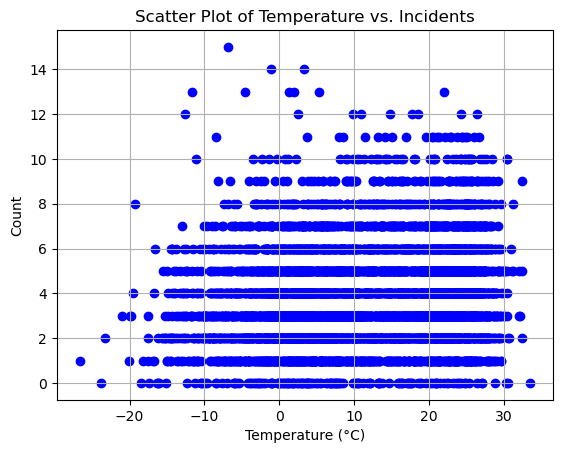

In [15]:
plt.scatter(mergdf['temp'], mergdf['count'], color='blue')
plt.title('Scatter Plot of Temperature vs. Incidents')
plt.xlabel('Temperature (°C)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(mergdf[date], counts_by_month, color='skyblue')
plt.title('Count by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [16]:
mergdf.head(5)

,date,count,name,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,...,description,icon,stations,full_moon,Holiday,Day of Week,CHIC917URN,day_of_week,year,month
0,2010-01-01,13.0,"Chicago,United States",-8.3,-14.5,-11.7,-15.0,-22.4,-19.0,-16.1,...,Partly cloudy throughout the day.,partly-cloudy-day,"72534014819,KORD,KMDW,72530094846,74466504838,...",NaN,New Year's Day,Friday,12.2,4,2010,1
1,2010-01-02,4.0,"Chicago,United States",-11.4,-16.4,-14.1,-18.4,-25.3,-22.6,-19.6,...,Partly cloudy throughout the day.,partly-cloudy-day,"72534014819,KORD,KMDW,72530094846,74466504838,...",NaN,NaN,NaN,12.2,5,2010,1
2,2010-01-03,3.0,"Chicago,United States",-7.9,-17.5,-12.5,-14.7,-25.6,-20.5,-17.6,...,Partly cloudy throughout the day.,partly-cloudy-day,"72534014819,KORD,KMDW,72530094846,74466504838,...",NaN,NaN,NaN,12.2,6,2010,1
3,2010-01-04,3.0,"Chicago,United States",-7.4,-13.1,-10.2,-14.4,-21.3,-17.6,-14.6,...,Cloudy skies throughout the day.,cloudy,"72534014819,KORD,KMDW,72530094846,74466504838,...",NaN,NaN,NaN,12.2,0,2010,1
4,2010-01-05,4.0,"Chicago,United States",-5.1,-9.5,-7.9,-11.7,-15.9,-14.2,-12.3,...,Cloudy skies throughout the day.,cloudy,"72534014819,KORD,KMDW,72530094846,74466504838,...",NaN,NaN,NaN,12.2,1,2010,1
